(rasch-estimation-notebook)=
# Stima

Per valutare e applicare il modello di Rasch nella ricerca pratica, è necessario essere in grado di stimare i parametri del modello basandosi su dati empirici. Presenteremo diversi approcci per stimare i parametri del modello di Rasch a partire dai dati dei test osservati. Tutti questi approcci possono essere utilizzati per stimare sia i parametri degli item sia quelli delle persone, ma lo fanno in modi diversi. Due degli approcci – la massima verosimiglianza congiunta e l'inferenza bayesiana – stimano i parametri delle persone e degli item simultaneamente. Gli altri due approcci – la massima verosimiglianza condizionale e la massima verosimiglianza marginale – li stimano separatamente, con i parametri delle persone che seguono in un secondo passaggio. 

In [1]:
source("../_common.R")

suppressPackageStartupMessages({
    library("grid")
    library("latex2exp")
    library("mirt")
    library("TAM")
    # devtools::install_github("masurp/ggmirt")
    library("ggmirt")
    library("cmdstanr")
    library("posterior")
    options(posterior.num_args = list(sigfig = 2)) # by default summaries with 2 significant digits
    library("rstan")
    library("bayesplot")
    color_scheme_set("brightblue")
    })

## La Funzione di Verosimiglianza

Tutti i metodi per la stima dei parametri nel modello di Rasch si basano sulla funzione di verosimiglianza, che rappresenta la probabilità dei dati osservati data una serie di parametri del modello ancora sconosciuti. In particolare, nel contesto del modello di Rasch, $ U_{pi} $ indica la risposta (corretta o errata) fornita dalla persona $ p $ all'item $ i $, dove una risposta corretta è codificata come 1 e una risposta errata come 0. La verosimiglianza della risposta della persona $ p $ all'item $ i $ è espressa dalla seguente formula:

$$ 
L_{upi}(\theta_p, \beta_i) = \text{Pr}(U_{pi} = u_{pi} | \theta_p, \beta_i) = \frac{\exp\{u_{pi} \cdot (\theta_p - \beta_i)\}}{1 + \exp(\theta_p - \beta_i)}. 
$$

Questa equazione calcola la probabilità che la persona $ p $ dia una risposta specifica $ u_{pi} $ all'item $ i $, in funzione del proprio livello di abilità $ \theta_p $ e della difficoltà dell'item $ \beta_i $.

Per calcolare la verosimiglianza complessiva delle risposte di una persona $ p $ a tutti gli item del test (da $ i = 1 $ a $ I $), moltiplichiamo le verosimiglianze di tutte le sue risposte. La formula diventa:

$$ 
\begin{align}
L_{up}(\theta_p, \beta) &= \prod_{i=1}^{I} \frac{\exp\{u_{pi} \cdot (\theta_p - \beta_i)\}}{1 + \exp(\theta_p - \beta_i)} \notag\\
&= \frac{\exp(rp \cdot \theta_p - \sum_{i=1}^{I} u_{pi} \cdot \beta_i)}{\prod_{i=1}^{I} [1 + \exp(\theta_p - \beta_i)]}.  
\end{align}
$$ (eq-rasch-likelihood)

Questa equazione rappresenta il punto di partenza per tutti gli approcci di stima dei parametri nel modello di Rasch. Tuttavia, il metodo specifico scelto per l'analisi dei dati influenzerà come i parametri relativi alle abilità delle persone ($ \theta_p $) e le difficoltà degli item ($ \beta_i $) vengono stimati e interpretati. Ogni approccio di stima ha le proprie peculiarità e assunzioni che determinano come queste stime vengono ottenute.

## Stima della Massima Verosimiglianza Congiunta

La stima della massima verosimiglianza congiunta, comunemente nota come JML, è un metodo che mira a identificare i parametri delle persone e degli item che massimizzano la probabilità complessiva dei dati osservati, come descritto nell'equazione di verosimiglianza del modello di Rasch. In sostanza, questo approccio seleziona i parametri ritenuti più probabili nell'avere generato il set di dati in esame.

Nonostante il suo approccio diretto e intuitivo, l'uso del metodo JML è relativamente limitato in pratica. Questo perché, in molti casi, non fornisce stime consistenti dei parametri degli item, anche quando il numero di persone nel campione è molto grande. Tale limitazione rende JML meno affidabile rispetto ad altri metodi, specialmente in contesti dove la precisione e la consistenza delle stime sono cruciali.

Nel contesto del software statistico `R`, è possibile applicare l'approccio JML utilizzando la funzione `tam.jml()` disponibile nel pacchetto `TAM`. Allo stesso modo, è possibile sfruttare funzioni di uso generale per la stima di modelli lineari generalizzati. Tuttavia, data la tendenza del metodo JML a non fornire stime affidabili e consistenti dei parametri degli item, il suo impiego è generalmente sconsigliato in analisi avanzate o in situazioni dove la precisione delle stime è di fondamentale importanza.

## Stima della Massima Verosimiglianza Condizionale

Per superare i limiti associati alla stima congiunta, si ricorre spesso alla stima della massima verosimiglianza condizionale, che segue un approccio in due fasi. In questo processo, i parametri degli item vengono stimati inizialmente, indipendentemente dai parametri delle persone, per poi procedere con la stima dei parametri individuali.

In una fase iniziale, l'analisi si concentra esclusivamente sui parametri degli item, utilizzando le cosiddette statistiche sufficienti delle persone. Questo permette di isolare e stimare i parametri degli item senza la necessità di conoscere preliminarmente i parametri delle persone. L'obiettivo è ottenere stime precise dei parametri degli item, che saranno poi utilizzate nella fase successiva.

Dopo aver stimato i parametri degli item, questi vengono utilizzati per stimare i parametri relativi alle persone. A questo punto, si presume che i parametri degli item siano stati calcolati con una precisione sufficiente da fornire basi affidabili per la stima dei parametri individuali.

La validità e l'accuratezza delle stime dei parametri delle persone dipendono fortemente dalla precisione raggiunta nella stima dei parametri degli item nella prima fase. Se i parametri degli item non sono stati stimati con un alto grado di accuratezza, le stime dei parametri delle persone potrebbero risultare meno attendibili.

La stima della massima verosimiglianza condizionale si presenta come un approccio sequenziale e metodico, affrontando le sfide della stima congiunta attraverso un processo che massimizza inizialmente la verosimiglianza degli item e, successivamente, quella delle persone. Tale metodo offre un equilibrio tra precisione e praticità, risultando particolarmente utile in contesti di stima complessi.

Nell'ambiente di programmazione `R`, la stima della massima verosimiglianza condizionale può essere realizzata attraverso la funzione `RM()` fornita dal pacchetto `eRm` (Mair, Hatzinger e Maier, 2021).

## Stima della Massima Verosimiglianza Marginale

La stima della massima verosimiglianza marginale rappresenta un approccio avanzato nell'analisi dei modelli di Rasch e si differenzia dalla stima della massima verosimiglianza condizionale. Mentre la stima condizionale fissa i parametri delle persone ai loro punteggi totali ottenuti nel test, la stima marginale "media" questi parametri dalla funzione di verosimiglianza complessiva.

In pratica, la stima della massima verosimiglianza marginale integra una distribuzione marginale, o di popolazione, per i parametri delle persone. Questa distribuzione rappresenta la probabilità relativa di ogni possibile livello di abilità all'interno della popolazione. Secondo De Ayala (2009), questo metodo considera le abilità come effetti casuali, simili ai modelli misti o multilivello, a differenza della stima congiunta che le tratta come effetti fissi.

Una scelta comune per la distribuzione marginale dei parametri delle persone è quella normale. Questo approccio si basa sull'ipotesi che le abilità siano distribuite simmetricamente nella popolazione, con la maggior parte delle persone che si raggruppa attorno alla media e relativamente poche che presentano valori estremamente alti o bassi. Ad esempio, questo si applica bene in contesti come la misurazione dell'intelligenza, dove si presume che la maggior parte delle persone abbia un'intelligenza media e solo una minoranza presenti livelli estremamente alti o bassi.

La stima della massima verosimiglianza marginale consente quindi di considerare la distribuzione delle abilità nella popolazione, portando a stime dei parametri degli item che sono più realistiche e precise, specialmente in situazioni dove le abilità variano in modo continuo e seguono una distribuzione nota o ipotizzata.

Nell'ambito di `R`, la stima della massima verosimiglianza marginale è implementata sia nel pacchetto `mirt` (Chalmers, 2021) che in `TAM` (Robitzsch et al., 2021). Un altro pacchetto che utilizzava questo metodo è `ltm` (Rizopoulos, 2006), sebbene non sia più attivamente mantenuto.

Analogamente alla stima condizionale, anche nell'approccio marginale, i parametri delle persone sono tipicamente stimati dopo una prima stima dei parametri degli item, in un processo noto come "scoring" o calcolo del punteggio.

### Implementazione

Consideriamo ora la procedura di stima del livello di abilità $\theta$ di un individuo nel modello di Rasch attraverso l'uso della massima verosimiglianza marginale. La procedura per stimare la posizione di un individuo, dato un particolare pattern di risposte, può essere formulata con i seguenti passaggi.

1. Consideriamo un determinato pattern di risposta. Per esempio, il pattern "11000" indica che un particolare individuo ha fornito due risposte corrette seguite da tre errate a cinque item, con un totale di $X = 2$ risposte corrette.

2. Calcoliamo le probabilità per ogni risposta. Utilizziamo l'Eq. {eq}`eq-rasch-model` per calcolare la probabilità di ciascuna risposta nel pattern, in base a un dato livello di abilità $\theta$.

3. Determiniamo la probabilità del pattern di risposta. Questo passaggio si basa sull'assunzione di indipendenza condizionale (ovvero, per un dato $\theta$, le risposte sono indipendenti l'una dall'altra). Questa assunzione ci permette di applicare la regola di moltiplicazione per eventi indipendenti alle probabilità degli item per ottenere la probabilità complessiva del pattern di risposta per un dato $\theta$.

4. Ripetiamo i calcoli per diversi valori di $\theta$. Ripetiamo i passaggi 1 e 2 per una serie di valori di $\theta$. Nel nostro esempio, il range di $\theta$ va da $-3$ a $3$.

5. Determiniamo il valore di $\theta$ con la massima verosimiglianza. L'ultimo passaggio consiste nel determinare quale valore di $\theta$ tra quelli calcolati nel passaggio 3 abbia la più alta verosimiglianza di produrre il pattern "11000". Per fare questo scegliamo il valore $\theta$ per cui la verosimiglianza è massima.

Di seguito, esaminiamo uno script in `R` che implementa questa procedura.

In [2]:
# Definiamo il pattern di risposta
response_pattern <- c(1, 1, 0, 0, 0)

# Range di valori di theta da esplorare
theta_values <- seq(-3, 3, by = 0.01)

# Funzione per calcolare la probabilità di un singolo pattern di risposta
calculate_probability <- function(theta, pattern) {
    correct_probs <- exp(theta) / (1 + exp(theta))
    item_probs <- ifelse(pattern == 1, correct_probs, 1 - correct_probs)
    prod(item_probs)
}
# Per semplicità, assumiamo che il parametro di difficoltà (beta) sia zero per tutti gli item.

# Calcoliamo le probabilità per ogni valore di theta. Usiamo sapply per applicare 
# la funzione calculate_probability a ciascun valore di theta nel range specificato.
probabilities <- sapply(theta_values, calculate_probability, pattern = response_pattern)

# Identifichiamo il valore di theta con la massima verosimiglianza
best_theta <- theta_values[which.max(probabilities)]

print(paste("Valore di theta calcolato con la massima verosimiglianza:", best_theta))


[1] "Valore di theta calcolato con la massima verosimiglianza: -0.41"


Questo script calcola la probabilità di ottenere il pattern di risposta "11000" per cinque item per un dato intervallo di valori di $\theta$ e identifica il valore di $\theta$ che massimizza questa probabilità. Si noti che il modello di Rasch prevede che tutti gli item abbiano la stessa discriminazione, quindi non è necessario specificare un parametro di discriminazione per ogni item. Abbiamo assunto inoltre che la difficoltà di tutti gli item sia uguale a zero.

La verosimiglianza di un pattern di risposta di un singolo rispondente a diversi item può essere rappresentata simbolicamente nel modo seguente. Se consideriamo $x$ come il pattern di risposta di un rispondente (ad esempio, $x = 11000$ indica che il rispondente ha risposto correttamente ai primi due item e ha dato risposte sbagliate agli ultimi tre), la verosimiglianza del vettore di risposta $x_i$ della persona $i$ è espressa come:

$$
\begin{equation}
L(x_i) = \prod_{j=1}^{L} p_{ij},
\end{equation}
$$

dove $p_{ij} = p(x_{ij} = 1 \mid \theta_i, \alpha_j, \delta_j)$ rappresenta la probabilità che la persona $i$, con un livello di abilità $\theta_i$, risponda correttamente all'item $j$. In questa formula, $\alpha_j$ è il parametro di discriminazione dell'item $j$ e $\delta_j$ è il suo parametro di difficoltà. Il parametro $\alpha_j$ indica quanto bene l'item $j$ è in grado di discriminare tra rispondenti di diversi livelli di abilità, mentre $\delta_j$ rappresenta il livello di abilità per cui la probabilità di una risposta corretta è del 50%. Il prodotto è calcolato su tutti gli $L$ item a cui il rispondente ha risposto, e il simbolo $\prod$ rappresenta il prodotto di tutte queste probabilità individuali.

Il calcolo diretto della verosimiglianza può diventare problematico all'aumentare del numero di item, poiché il prodotto di molteplici probabilità può risultare in valori molto piccoli, difficili da gestire con precisione in calcoli numerici. Pertanto, è spesso più pratico lavorare con la trasformazione logaritmica naturale della verosimiglianza, ovvero $\log_e(L(x_i))$ o $\ln(L(x_i))$. Questa trasformazione converte il prodotto in una somma, come segue:

$$
\begin{equation}
\ln L(x_i) = \sum_{j=1}^{L} \ln(p_{ij}).
\end{equation}
$$

L'uso del logaritmo naturale trasforma quindi la verosimiglianza in una somma di logaritmi, semplificando il calcolo e riducendo i problemi di rappresentazione numerica nei calcoli complessi.

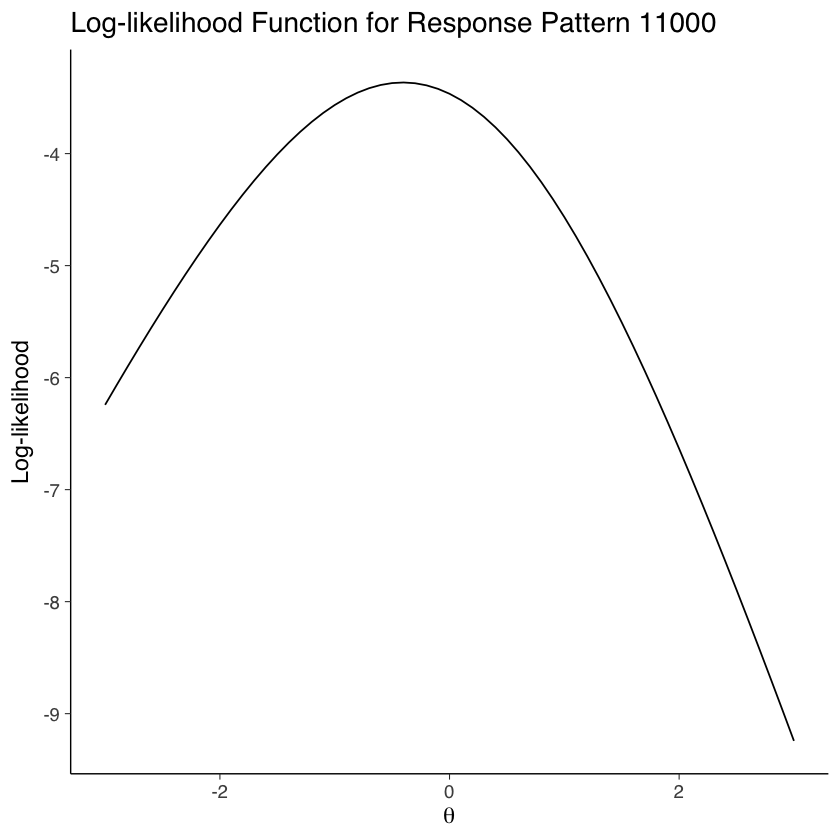

In [3]:
# Definizione del pattern di risposta
response_pattern <- c(1, 1, 0, 0, 0)

# Range di valori di theta da esplorare
theta_values <- seq(-3, 3, by = 0.1)

# Calcolo della log-verosimiglianza per ogni valore di theta
log_likelihoods <- numeric(length(theta_values))
for (i in seq_along(theta_values)) {
    theta <- theta_values[i]
    log_item_probs <- numeric(length(response_pattern))

    # Calcolo delle probabilità logaritmiche individuali per ogni item nel pattern
    for (j in seq_along(response_pattern)) {
        prob_correct <- exp(theta) / (1 + exp(theta))
        prob <- ifelse(response_pattern[j] == 1, prob_correct, 1 - prob_correct)
        log_item_probs[j] <- log(prob)
    }

    # Calcolo della log-verosimiglianza
    log_likelihoods[i] <- sum(log_item_probs)
}

# Creazione di un dataframe per il plotting
plot_data <- data.frame(theta = theta_values, log_likelihood = log_likelihoods)

# Rappresentazione grafica della log-verosimiglianza
ggplot(plot_data, aes(x = theta, y = log_likelihood)) +
    geom_line() +
    labs(
        x = expression(theta), y = "Log-likelihood",
        title = "Log-likelihood Function for Response Pattern 11000"
    ) 

## Errore Standard della Stima e Informazione dell'Item

Nel contesto del modello di Rasch, l'Errore Standard della Stima (EES) è un indice cruciale che misura l'incertezza associata alla stima del livello di abilità di un individuo, $\theta$. L'EES è fondamentale perché offre una misura di quanto fiduciosamente possiamo affermare che la stima di $\theta$ rifletta l'abilità reale del rispondente.

Nel modello di Rasch, l'EES per un dato livello di abilità $\theta$ è calcolato come l'inverso della radice quadrata dell'informazione totale dell'item a quel livello di abilità. Matematicamente, l'EES è espresso come segue:

$$
\begin{equation}
\text{EES}(\theta) = \frac{1}{\sqrt{I(\theta)}},
\end{equation}
$$

dove $I(\theta)$ rappresenta l'informazione totale dell'item a un dato livello di abilità $\theta$. L'informazione dell'item, a sua volta, è una funzione della probabilità di una risposta corretta e della probabilità di una risposta errata per ciascun item, e viene calcolata come:

$$
\begin{equation}
I(\theta) = \sum_{j=1}^{L} p_{ij}(1 - p_{ij}),
\end{equation}
$$

dove $L$ è il numero totale di item, e $p_{ij}$ è la probabilità di una risposta corretta all'item $j$ da parte di una persona con abilità $\theta$.

Questo concetto di informazione dell'item è fondamentale nel modello di Rasch. L'informazione fornita da un item varia in base al livello di abilità del rispondente e raggiunge il suo massimo quando la difficoltà dell'item ($\delta_j$) è uguale al livello di abilità del rispondente ($\theta$). Pertanto, gli item che sono più informativi per un dato livello di abilità contribuiscono maggiormente alla precisione della stima di $\theta$ per quel livello.

Per rappresentare graficamente l'informazione dell'item, possiamo tracciare l'informazione fornita da ciascun item su un grafico in funzione del livello di abilità $\theta$. Questo grafico è noto come "curva di informazione dell'item" e illustra come ogni item contribuisca diversamente all'informazione totale in base al livello di abilità del rispondente.

### Stima dell'Abilità 

Nel contesto della IRT, la stima dell'abilità di un esaminando può essere effettuata attraverso metodi di massima verosimiglianza. Il processo inizia con un'ipotesi iniziale o un valore a priori dell'abilità dell'esaminando. Questo valore può essere basato su considerazioni teoriche o su una media presunta dell'abilità.

I valori noti dei parametri degli item del test (ad esempio, difficoltà e discriminazione degli item) vengono utilizzati per calcolare la probabilità che l'esaminando risponda correttamente a ciascun item, in base al livello di abilità iniziale ipotizzato.

Il valore dell'abilità viene poi aggiustato iterativamente. L'obiettivo di questo aggiustamento è migliorare la corrispondenza tra le probabilità calcolate di risposta corretta e il pattern effettivo di risposte dell'esaminando (vettore di risposta). Questo si basa sull'idea che una migliore stima dell'abilità porterà a una maggiore coerenza tra le risposte osservate e quelle previste dai parametri degli item. L'iterazione continua fino a quando le modifiche alla stima dell'abilità diventano trascurabili, indicando che la stima ha raggiunto un punto di convergenza. Il risultato finale è una stima affidabile del parametro di abilità per quell'esaminando.

Questo processo viene applicato separatamente a ciascun esaminando che ha completato il test, assicurando che ogni stima di abilità sia personalizzata e basata sulle risposte specifiche fornite.

Esistono anche metodi che permettono la stima simultanea dei livelli di abilità di tutti gli esaminandi. Tali metodi sono particolarmente utili per ottimizzare il processo di stima in contesti con un grande numero di rispondenti.

La stima dell'abilità è fondamentale in IRT per due ragioni principali:

- Consente di valutare l'abilità di ciascun esaminando in maniera individualizzata, tenendo conto delle specifiche interazioni tra l'esaminando e gli item del test.

- Fornisce una misura accurata dell'abilità che è direttamente legata ai parametri degli item, permettendo analisi dettagliate e mirate sull'efficacia del test e sulle caratteristiche degli esaminandi.

In conclusione, la stima dell'abilità in IRT è un processo iterativo che sfrutta i parametri degli item per produrre stime precise dell'abilità degli esaminandi. 

## Stima Bayesiana

La stima bayesiana sta diventando un metodo sempre più popolare per stimare i parametri del modello di Rasch. Come la stima della massima verosimiglianza congiunta, la stima bayesiana stima simultaneamente sia i parametri delle persone che quelli degli item. Tuttavia, mentre la stima della massima verosimiglianza congiunta trova i valori di $ \theta $ e $ \beta $ massimizzando la verosimiglianza congiunta, la stima bayesiana utilizza la regola di Bayes per trovare la densità a posteriori, $ f(\theta,\beta \mid u) $. Per un'introduzione all'inferenza bayesiana, si veda l'Appendice B.1.4.

Nel modello di Rasch, la regola di Bayes afferma che:

$$ 
f(\theta,\beta \mid u) = \frac{\text{Pr}(u \mid \theta,\beta)f(\theta,\beta)}{\text{Pr}(u)}. 
$$

Il primo termine nel numeratore, $ \text{Pr}(u | \theta, \beta) $, è la verosimiglianza congiunta. Il secondo è la distribuzione a priori congiunta per $ \theta $ e $ \beta $. Il denominatore è la probabilità media dei dati osservati rispetto alla distribuzione a priori congiunta.

A differenza della stima della massima verosimiglianza, che si concentra sulla massimizzazione della verosimiglianza, la stima bayesiana integra le informazioni a priori con i dati osservati. La regola di Bayes combina la verosimiglianza dei dati osservati (la probabilità di osservare i dati dati i parametri) con la distribuzione a priori (le nostre credenze sui parametri prima di osservare i dati) per produrre una distribuzione a posteriori (le nostre credenze aggiornate sui parametri dopo aver osservato i dati). La densità a posteriori $ f(\theta,\beta \mid u) $ ci fornisce una stima completa dei parametri, considerando sia i dati osservati sia le informazioni a priori.

In pratica, la stima bayesiana fornisce un approccio flessibile e informativo alla stima dei parametri nel modello di Rasch, consentendo l'integrazione di conoscenze pregresse e osservazioni attuali.

### Implementazione

Esaminiamo un'applicazione della stima Bayesiana usando il linguaggio probabilistico Stan. Il modello di Rasch è implementato nel file `rasch_model.stan` utilizzando le distribuzioni a priori specificate da {cite:t}`debelak2022introduction`. 

In [4]:
stan_file <- "../code/rasch_model.stan"
mod <- cmdstan_model(stan_file)
mod$print()

data {
  int<lower=1> num_person;
  int<lower=1> num_item;
  array[num_person, num_item] int<lower=0, upper=1> U;
}
parameters {
  vector[num_person] theta;
  vector[num_item] beta;
  real mu_beta;
  real<lower=0> sigma2_theta;
  real<lower=0> sigma2_beta;
}
transformed parameters {
  array[num_person, num_item] real<lower=0, upper=1> prob_solve;
  for (p in 1:num_person) 
    for (i in 1:num_item) 
      prob_solve[p, i] = inv_logit(theta[p] - beta[i]);
}
model {
  for (p in 1:num_person) 
    for (i in 1:num_item) 
      U[p, i] ~ bernoulli(prob_solve[p, i]);
  theta ~ normal(0, sqrt(sigma2_theta));
  beta ~ normal(mu_beta, sqrt(sigma2_beta));
  sigma2_theta ~ inv_chi_square(0.5);
  sigma2_beta ~ inv_chi_square(0.5);
}




Compiliamo il modello usando CmdStan:

In [5]:
mod$compile()

Definiamo i dati nel formato appropriato per Stan:

In [6]:
data(data.fims.Aus.Jpn.scored, package = "TAM")
people <- 1:400
responses <- data.fims.Aus.Jpn.scored[people, 2:15]
responses <- as.matrix(sapply(responses, as.integer))
colnames(responses) <- gsub("M1PTI", "I", colnames(responses))

stan_data <- list(
    num_person = nrow(responses),
    num_item = ncol(responses),
    U = responses
)

Eseguiamo il campionamento MCMC per ottenere la distribuzione a posteriori dei parametri.

In [7]:
fit <- mod$sample(
    data = stan_data,
    chains = 4, # Number of MCMC chains
    parallel_chains = 2, # Number of chains to run in parallel 
    iter_warmup = 2000, # Number of warmup iterations per chain
    iter_sampling = 2000, # Number of sampling iterations per chain
    seed = 1234 # Set a seed for reproducibility
)

Running MCMC with 4 chains, at most 2 in parallel...

Chain 1 Iteration:    1 / 4000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:



Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/cl/wwjrsxdd5tz7y9jr82nd5hrw0000gn/T/RtmpNDB3FZ/model-a4fc65a663ef.stan', line 23, column 2 to column 40)



Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,



Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Chain 1 



Esaminiamo le tracce per due parametri.

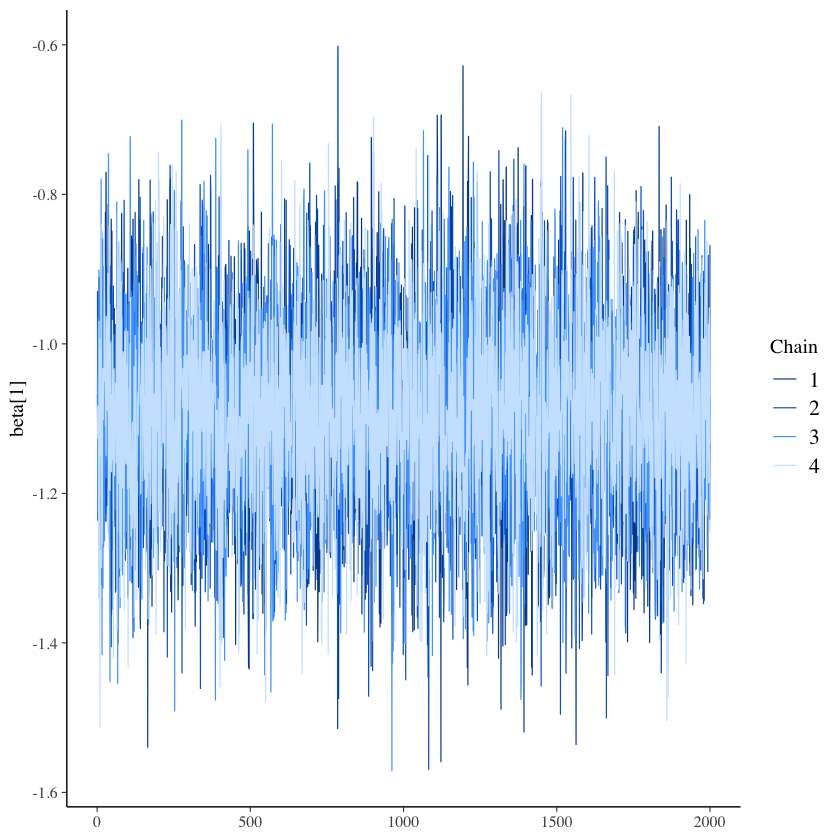

In [10]:
fit_draws <- fit$draws() # extract the posterior draws
mcmc_trace(fit_draws, pars = c("beta[1]"))

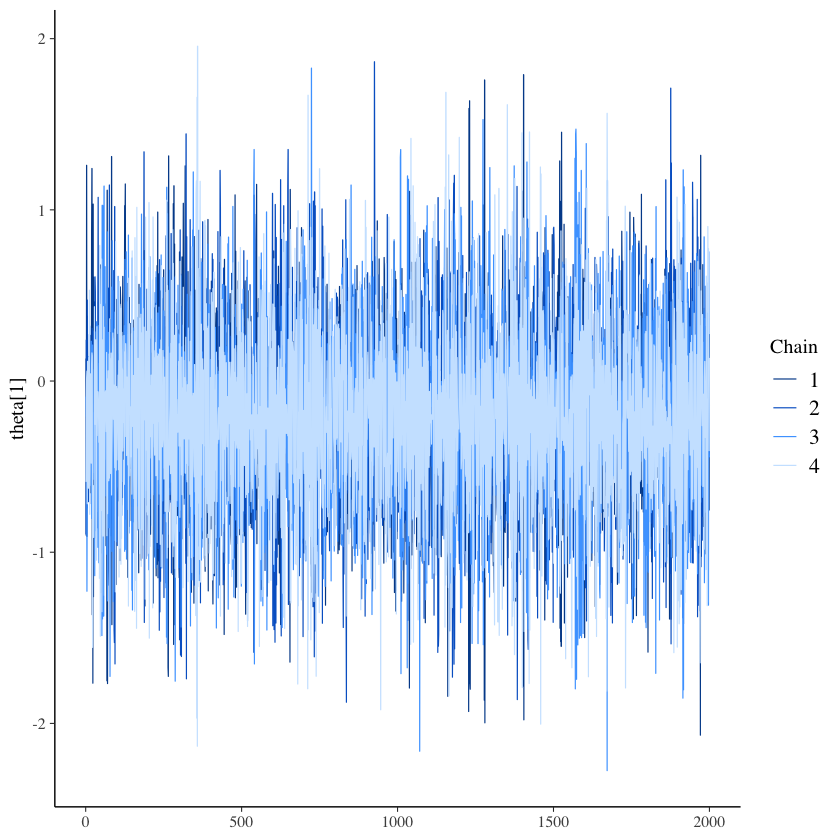

In [26]:
mcmc_trace(fit_draws, pars = c("theta[1]"))

Focalizziamoci sulla stima dei parametri degli item.

In [48]:
parameters <- c(
    "beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]", 
    "beta[6]", "beta[7]", "beta[8]", "beta[9]","beta[10]",
    "beta[11]", "beta[12]", "beta[13]", "beta[14]"
)

Esaminiamo la statistica rhat.

In [ ]:
rhats <- rhat(fit, pars = parameters)
mcmc_rhat(rhats)

Esaminiamo l'effect ratio:

beta[1]  beta[2]  beta[3]  beta[4]  beta[5]  beta[6]  beta[7]  beta[8] 
1.273847 1.407462 1.428233 1.414457 1.504470 1.248790 1.344980 1.276763 
 beta[9] beta[10] beta[11] beta[12] beta[13] beta[14] 
1.377675 1.381960 1.209758 1.372889 1.446516 1.531970

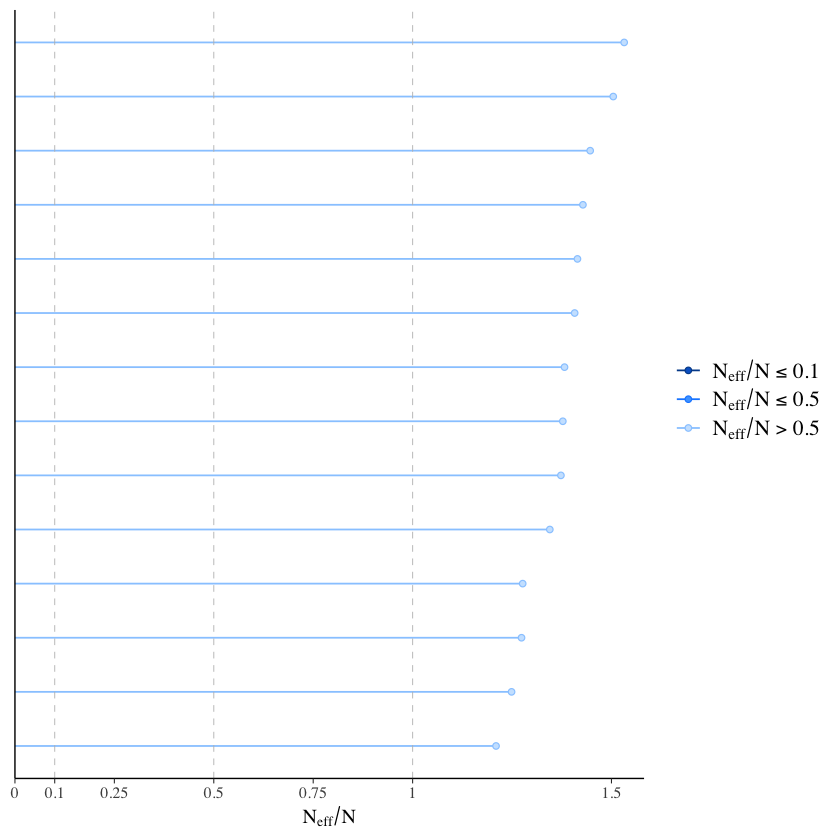

In [40]:
eff_ratio <- neff_ratio(fit, pars = parameters)
eff_ratio
mcmc_neff(eff_ratio) 

Esaminiamo l'autocorrelazione.

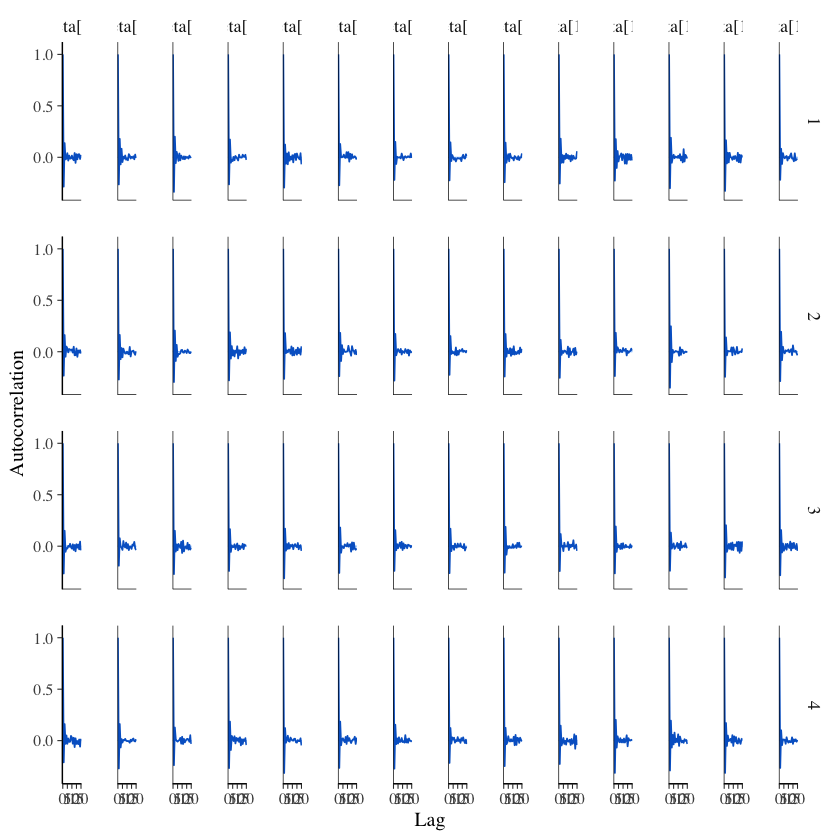

In [41]:
mcmc_acf(fit_draws, pars = parameters)

Otteniamo le statistiche riassuntive delle distribuzioni a posteriori dei parametri degli item.

In [42]:
fit$summary(
    variables = parameters,
    posterior::default_summary_measures(),
    extra_quantiles = ~ posterior::quantile2(., probs = c(.0275, .975))
)

variable,mean,median,sd,mad,q5,q95,q2.75,q97.5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
beta[1],-1.09521476,-1.09537000,0.1304091,0.1312842,-1.3092705,-0.8820211,-1.3443603,-0.8388891
beta[2],-1.24253352,-1.24135500,0.1313470,0.1309506,-1.4615260,-1.0269185,-1.4992133,-0.9863208
beta[3],-2.02671281,-2.02360000,0.1567218,0.1539977,-2.2923890,-1.7737775,-2.3393100,-1.7265945
beta[4],-0.04414424,-0.04340395,0.1205291,0.1193946,-0.2387502,0.1589901,-0.2784402,0.1968133
beta[5],2.51568910,2.51373000,0.1816456,0.1800395,2.2202780,2.8257825,2.1728542,2.8841950
beta[6],-1.24166937,-1.24235500,0.1332769,0.1306690,-1.4602125,-1.0211415,-1.4975705,-0.9790221
beta[7],0.81428138,0.81290700,0.1219776,0.1212544,0.6174932,1.0195295,0.5845436,1.0573417
beta[8],-0.49011747,-0.48967750,0.1201932,0.1213716,-0.6849435,-0.2975304,-0.7213573,-0.2559937
beta[9],1.32575024,1.32513000,0.1321416,0.1334859,1.1095705,1.5428550,1.0748981,1.5843330


I risultati ottenuti replicano quelli riportati da {cite:t}`debelak2022introduction`.

## Informazione

Nel contesto della psicometria e della statistica, il concetto di "informazione" assume un significato tecnico specifico, collegato alla precisione con cui è possibile stimare un parametro. Questa nozione, attribuita a Sir R.A. Fisher, definisce l'informazione come l'inverso della varianza con la quale un parametro può essere stimato. Dunque, un'alta precisione nella stima (ovvero una bassa variabilità) implica una maggiore quantità di informazione riguardo al valore del parametro.

### Funzione Informativa dell'Item

In termini della IRT, l'interesse si concentra sulla stima del parametro di abilità di un esaminando, denotato da $ \theta $. L'informazione relativa a un dato livello di abilità è data dall'inverso della varianza della stima di quell'abilità. Una grande quantità di informazione indica che il livello di abilità corrispondente può essere stimato con precisione, mentre una piccola quantità di informazione suggerisce una stima meno precisa e più dispersa attorno al valore vero dell'abilità.

L'informazione nella IRT è additiva rispetto agli item. L'informazione fornita da un singolo item $ i $ a un dato livello di abilità $ \theta_p $ è espressa dalla formula:

$$ 
I_i(\theta_p) = \text{Pr}(U_{pi} = 1 \mid \theta_p, \beta_i) \cdot (1 - \text{Pr}(U_{pi} = 1 \mid \theta_p, \beta_i)).
$$ 

Per il modello di Rasch, l'informazione è equivalente alla pendenza della Curva Caratteristica dell'Item (ICC) in un punto specifico. Maggiore è la pendenza dell'ICC, maggiore è la differenza nella probabilità per una data differenza di abilità, permettendo di stimare con maggiore precisione l'abilità di un esaminando quando questa è vicina alla difficoltà dell'item.

La stima dell'abilità e della difficoltà degli item può essere dimostrata con un esempio in R. Utilizzando il modello di Rasch, possiamo calcolare le probabilità di risposta corretta per diversi valori di abilità e, di conseguenza, la *Funzione Informativa dell'Item* (*Item Information Function*, IIF):

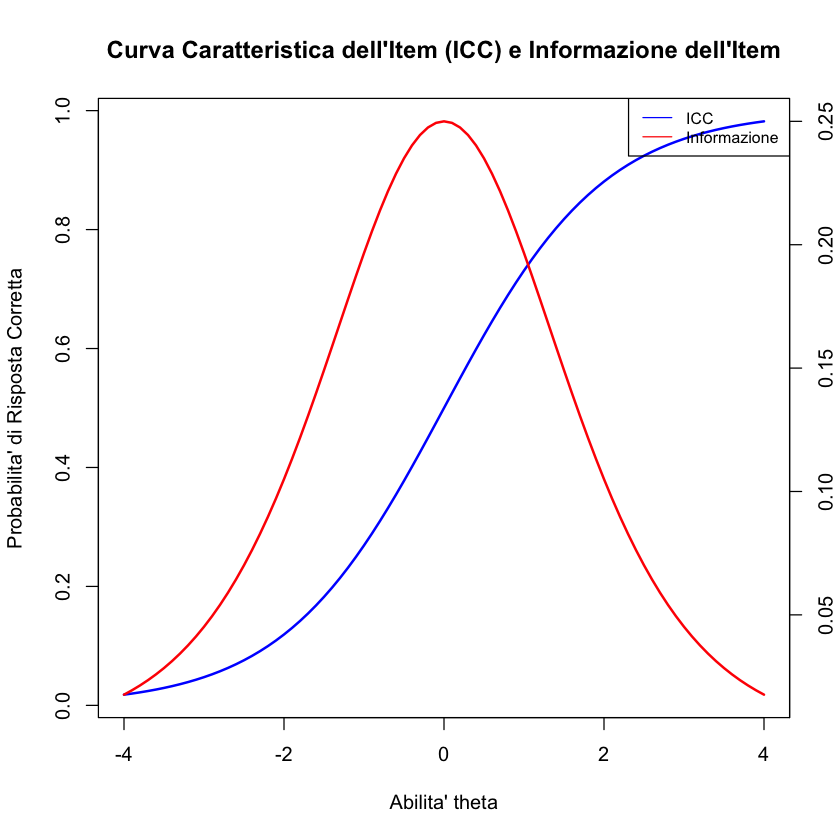

In [5]:
# Definizione di un range di abilità
theta <- seq(-4, 4, by = 0.1)

# Definizione di un parametro di difficoltà dell'item
beta <- 0

# Calcolo delle probabilità di risposta corretta per ciascun valore di abilità usando la funzione logistica
prob_correct <- exp(theta - beta) / (1 + exp(theta - beta))

# Calcolo dell'informazione dell'item
item_info <- prob_correct * (1 - prob_correct)

# Creazione della prima grafica (ICC)
plot(theta, prob_correct,
    type = "l", col = "blue", lwd = 2,
    xlab = "Abilita' theta", ylab = "Probabilita' di Risposta Corretta",
    main = "Curva Caratteristica dell'Item (ICC) e Informazione dell'Item"
)

# Aggiunta di un secondo asse y per l'informazione
par(new = TRUE)
plot(theta, item_info,
    type = "l", col = "red", lwd = 2,
    xlab = "", ylab = "", axes = FALSE, ann = FALSE
)

# Aggiungere l'asse y di destra per l'informazione
axis(side = 4, at = pretty(range(item_info)))
mtext("Informazione", side = 4, line = 3)

# Aggiunta della legenda
legend("topright",
    legend = c("ICC", "Informazione"),
    col = c("blue", "red"), lty = 1, cex = 0.8
)

Questa rappresentazione grafica in R mostra come l'informazione vari in funzione del livello di abilità. In generale, l'informazione è massima quando l'abilità dell'esaminando è vicina alla difficoltà dell'item e diminuisce man mano che ci si allontana da questo punto.

Il concetto di informazione in IRT è fondamentale sia per la costruzione del test sia per la sua interpretazione. Indica quanto efficacemente ciascun item misura l'abilità a vari livelli e aiuta a determinare quali item sono più informativi per la stima dell'abilità degli esaminandi. Inoltre, fornisce indicazioni sulla precisione con cui l'abilità degli esaminandi può essere stimata a vari punti lungo la scala di abilità.

### Funzione di Informazione del Test (TIF)

L'analisi dell'informazione fornita da un test nella Teoria delle Risposte agli Item (IRT) si amplia ulteriormente considerando la Funzione di Informazione del Test (TIF). Questa funzione è essenziale per comprendere quanto efficacemente un test nel suo insieme stima l'abilità degli esaminandi a vari livelli.

1. **Definizione della TIF**: La TIF è definita come la somma delle informazioni fornite da ciascun item a un determinato livello di abilità. Matematicamente, se $ I(\theta) $ rappresenta l'ammontare di informazione del test a un livello di abilità $ \theta $, e $ I_j(\theta) $ è l'informazione fornita dall'item $ j $ a quel livello, allora la TIF è data da:
   
   $$ I(\theta) = \sum_{j=1}^{J} I_j(\theta), $$

   dove $ J $ è il numero di item nel test.

2. **Livello Generale della TIF**: La TIF di un test è generalmente molto più alta rispetto all'informazione fornita da un singolo item. Questo implica che un test, come insieme di item, stima l'abilità in modo più preciso rispetto a un singolo item.

3. **Relazione tra Lunghezza del Test e Informazione**: Un principio importante evidenziato dalla TIF è che, in generale, i test più lunghi forniscono una stima dell'abilità con maggiore precisione rispetto ai test più brevi. Questo è dovuto al fatto che l'aggiunta di item aumenta la quantità totale di informazione disponibile.

4. **Grafico della TIF**: Tracciando l'ammontare di informazione del test contro i livelli di abilità, si ottiene un grafico della TIF. Per esempio, per un test di dieci item, il valore massimo della TIF potrebbe essere modesto e la quantità di informazione potrebbe diminuire progressivamente man mano che il livello di abilità si discosta da quello corrispondente al massimo. Questo indica che l'abilità viene stimata con una certa precisione vicino al centro della scala di abilità, ma la precisione diminuisce significativamente ai suoi estremi.

5. **Utilità della TIF**: La TIF è estremamente utile in IRT perché indica quanto bene il test stima l'abilità su tutta la gamma dei punteggi di abilità. Sebbene una TIF ideale possa essere una linea orizzontale, ciò potrebbe non essere ottimale per scopi specifici. Ad esempio, in un test per assegnare borse di studio, una TIF con un picco al punteggio di taglio potrebbe essere più appropriata.

6. **Dipendenza dal Modello di ICC**: La definizione matematica dell'informazione di un item dipende dal modello di curva caratteristica dell'item impiegato. Ogni modello fornisce una formula specifica per calcolare l'informazione fornita da un item.

Per dimostrare come calcolare la TIF in `R`, possiamo estendere l'esempio precedente includendo più item e sommando le loro informazioni:

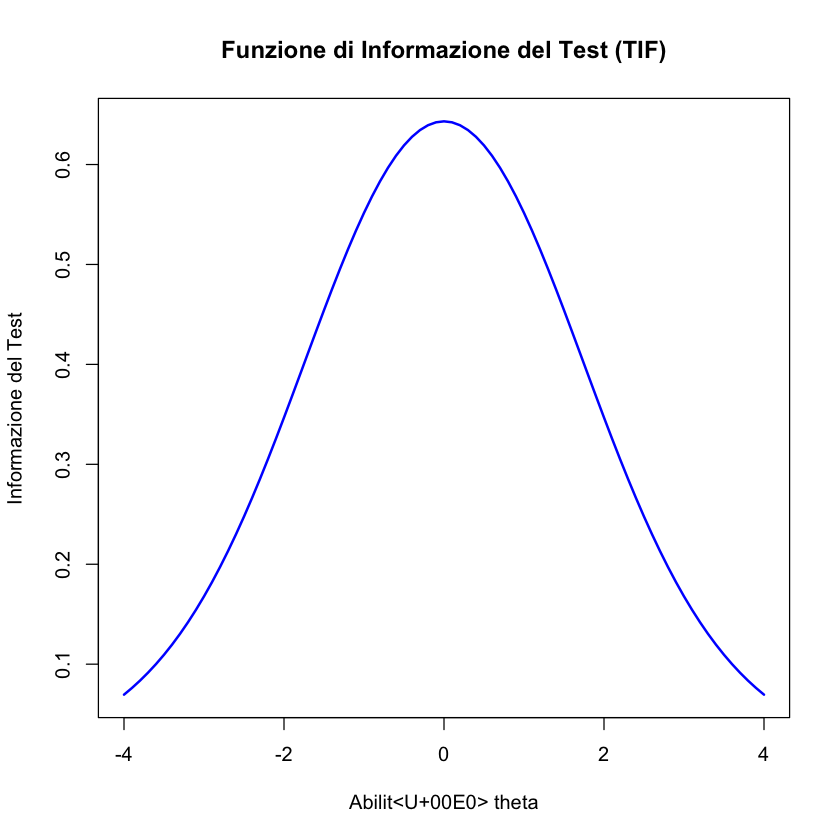

In [6]:
# Definizione di parametri di difficoltà per diversi item
beta_items <- c(-1, 0, 1) # Esempio di tre item con difficoltà diverse

# Calcolo dell'informazione per ogni item e somma per ottenere la TIF
test_info <- rep(0, length(theta))
for (beta in beta_items) {
    prob_correct <- exp(theta - beta) / (1 + exp(theta - beta))
    item_info <- prob_correct * (1 - prob_correct)
    test_info <- test_info + item_info
}

# Creazione del grafico della TIF
plot(theta, test_info,
    type = "l", col = "blue", lwd = 2,
    xlab = "Abilità theta", ylab = "Informazione del Test",
    main = "Funzione di Informazione del Test (TIF)"
)

In questo esempio, calcoliamo e sommiamo le informazioni di tre item con diverse difficoltà per visualizzare la TIF di un test ipotetico. La TIF mostra in modo chiaro come il test nel suo insieme stima l'abilità degli esaminandi a vari livelli, fornendo così indicazioni preziose sulla costruzione e sull'utilizzo ottimale del test in diversi contesti.

## Grandezza del Campione

La stima dei parametri degli item basata su un campione osservato di risposte è spesso definita come la *calibrazione degli item*. Generalmente, un campione di calibrazione più ampio consente una stima più accurata dei parametri degli item, sebbene altri fattori influenzino anch'essi l'accuratezza della stima. Ad esempio, la difficoltà di un item può essere stimata con maggiore precisione se l'item non è né troppo facile né troppo difficile per il campione di partecipanti al test. Pertanto, i fattori che influenzano l'accuratezza della stima includono l'allineamento e la forma delle distribuzioni dei parametri degli item e delle persone, il numero di item e la tecnica di stima utilizzata.

Diverse pubblicazioni hanno affrontato la questione della dimensione del campione tipicamente necessaria per lavorare con il modello di Rasch e come questa sia influenzata da questi e altri fattori. Ad esempio, De Ayala (2009) fornisce la linea guida generale che un campione di calibrazione dovrebbe contenere almeno diverse centinaia di rispondenti e cita, tra le altre referenze, un articolo precedente di Wright (1977) che afferma che un campione di calibrazione di 500 sarebbe più che adeguato. De Ayala (2009) suggerisce anche che 250 o più rispondenti sono necessari per adattare un modello di Partial Credit. Poiché il modello di Partial Credit è una generalizzazione del modello di Rasch con più parametri degli item, ciò implica che la dimensione del campione suggerita di 250 dovrebbe essere sufficiente anche per adattare un modello di Rasch. Studi più recenti hanno indagato l'applicazione del modello di Rasch con dimensioni del campione di soli 100 rispondenti (ad esempio, Steinfeld & Robitzsch, 2021; Suárez-Falcón & Glas, 2003). Tali linee guida non devono essere interpretate come regole fisse, ma solo come indicazioni generali in quanto una dimensione del campione adeguata dipende dalle condizioni e dagli obiettivi dell'analisi.

Un metodo più elaborato per determinare la dimensione del campione necessaria è l'analisi della potenza statistica. Qui, l'accuratezza della stima desiderata o il rischio di falsi positivi e falsi negativi devono essere formalizzati prima dell'analisi. La dimensione del campione necessaria viene quindi determinata in base a queste considerazioni. 


## Session Info

In [2]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.3.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C

time zone: Europe/Rome
tzcode source: internal

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] rstan_2.32.5       StanHeaders_2.32.5 posterior_1.5.0    cmdstanr_0.7.1    
 [5] ggmirt_0.1.0       TAM_4.2-21         CDM_8.2-6          mvtnorm_1.2-4     
 [9] mirt_1.41          lattice_0.22-5     latex2exp_0.9.6    ggokabeito_0.1.0  
[13] viridis_0.6.5      viridisLite_0.4.2  ggpubr_0.6.0       ggExtra_0.10.1    
[17] bayesplot_1.11.1   gridExtra_2.3      patchwork_1.2.0    semTools_0.5-6    
[21] semPlot_1.1.6      lavaan_0.6-17      psy